In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_file = "/home/olle/PycharmProjects/LODE/workspace/sequence_data/longitudinal_properties.csv"
data_pd = pd.read_csv(data_file)

#### How many sequence are treated?

In [3]:
print(f"number of treated sequences {data_pd.shape[0]}")

number of treated sequences 496


#### Insertion type distribution

Text(0.5, 1.0, 'month 24')

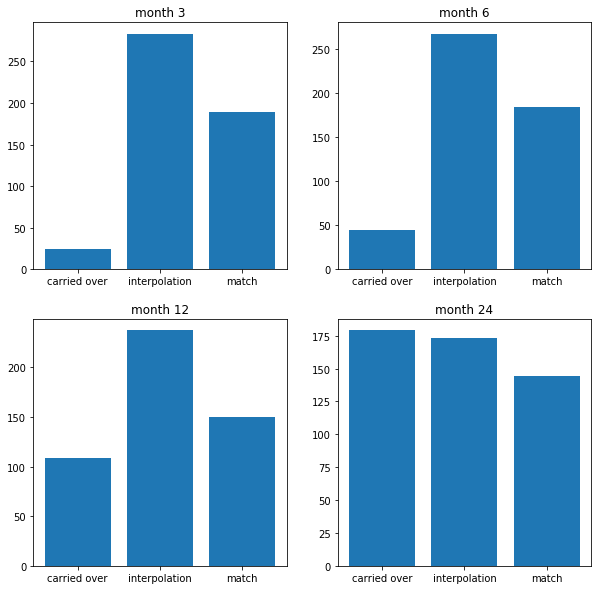

In [4]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))

month_3 = data_pd.groupby(['insertion_type_3']).size().tolist()
month_6 = data_pd.groupby(['insertion_type_6']).size().tolist()
month_12 = data_pd.groupby(['insertion_type_12']).size().tolist()
month_24 = data_pd.groupby(['insertion_type_24']).size().tolist()

x_labels = ["carried over", "interpolation", "match"]

ax1.bar(x_labels, month_3,align='center')
ax1.set_title("month 3")
ax2.bar(x_labels,month_6,align='center')
ax2.set_title("month 6")
ax3.bar(x_labels,month_12,align='center')
ax3.set_title("month 12")
ax4.bar(x_labels,month_24,align='center')
ax4.set_title("month 24")

In [5]:
#### carried over time distribution

Text(0.5, 1.0, 'Time from carry over')

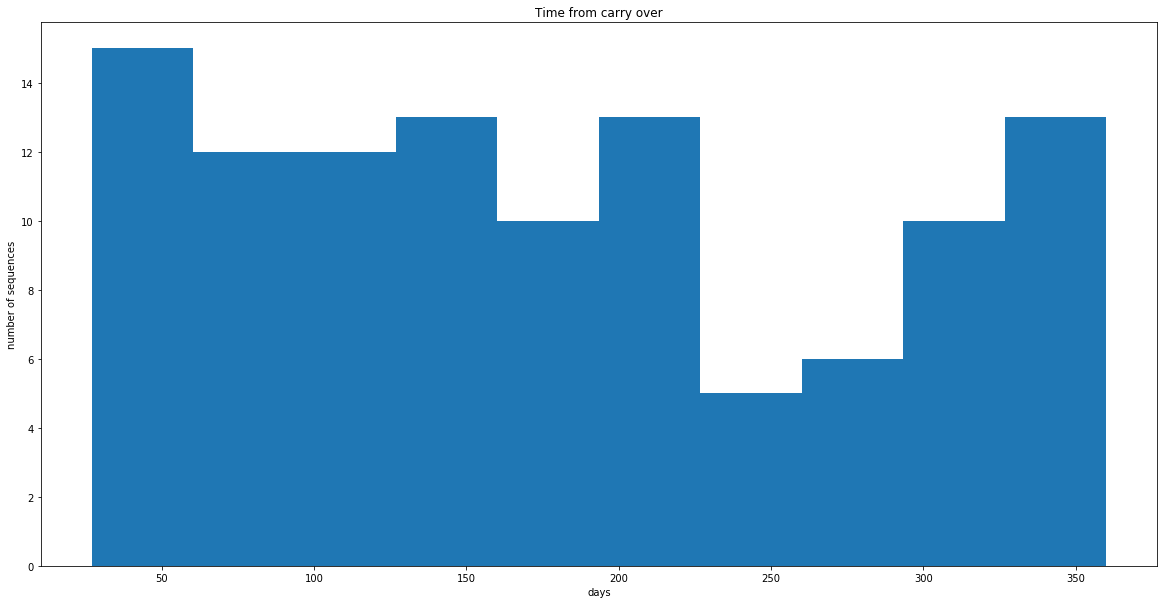

In [6]:
plt.figure(figsize=(20,10))
month_12_carry_over = data_pd.loc[data_pd.insertion_type_12 == "carry_over"]
plt.hist(month_12_carry_over.time_range_12)
plt.xlabel("days")
plt.ylabel("number of sequences")
plt.title("Time from carry over")


#### Time until dry

In [17]:
start_dry = data_pd.total_fluid_1 == 0

print(f"Number of sequences starting as dry: ", sum(start_dry))

# exclude dry start sequences
fluid_pd = data_pd.loc[~start_dry]

print(f"Number of sequences dry after 3 months: ", sum(fluid_pd.total_fluid_3 == 0))
print(f"Number of sequences dry after 6 months: ", sum(fluid_pd.total_fluid_6 == 0))
print(f"Number of sequences dry after 12 months: ", sum(fluid_pd.total_fluid_12 == 0))
print(f"Number of sequences dry after 24 months: ", sum(fluid_pd.total_fluid_24 == 0))



Number of sequences starting as dry:  3
Number of sequences dry after 3 months:  2
Number of sequences dry after 6 months:  1
Number of sequences dry after 12 months:  1
Number of sequences dry after 24 months:  3


In [ ]:
#### events pd

In [34]:
events_path = "/home/olle/PycharmProjects/LODE/workspace/sequence_data/longitudinal_events.csv"

events_pd = pd.read_csv(events_path)
# events_pd.groupby(["patient_id", "laterality"]).min("study_date")

events_pd["study_date_dt"] = pd.to_datetime(events_pd.study_date)

events_date_check = events_pd.groupby(['patient_id', 'laterality'])['study_date_dt'].nsmallest(1) 

In [42]:
events_date_check = pd.DataFrame(events_date_check)
events_date_check = events_date_check.reset_index()[["patient_id", "laterality", "study_date_dt"]]

In [43]:
events_date_check.to_csv("/home/olle/PycharmProjects/LODE/workspace/sequence_data/events_check.csv")

In [ ]:
#### How many sequences were cut to fit the 1 - 3 - 6 - 12 - 24

Text(0, 0.5, 'number of sequences')

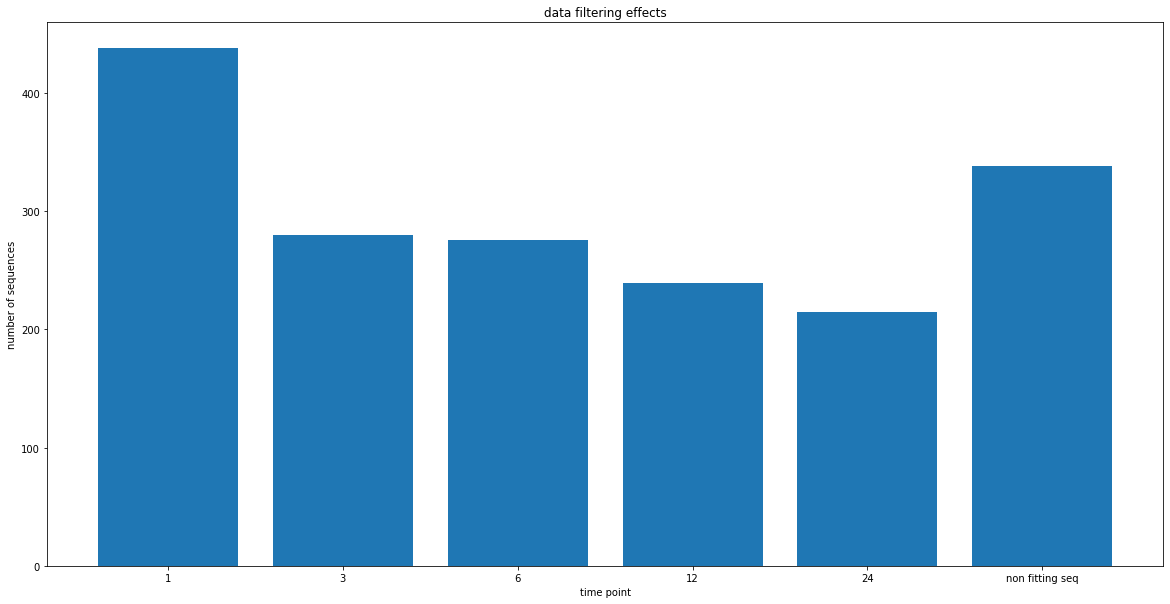

In [64]:
# filter for treated sequences
treated_pd = data_pd.loc[data_pd.cumsum_injections_1 > 0]

n_1 = treated_pd.study_date_1.dropna().shape[0]
n_3 = treated_pd.study_date_3.dropna().shape[0]
n_6 = treated_pd.study_date_6.dropna().shape[0]
n_12 = treated_pd.study_date_12.dropna().shape[0]
n_24 = treated_pd.study_date_24.dropna().shape[0]


bool3 = treated_pd.study_date_3.isna()
bool6 = treated_pd.study_date_6.isna() 
bool12 = treated_pd.study_date_12.isna()

numbers_to_exclude = treated_pd.loc[bool3 | bool6 | bool12].shape[0]

plt.figure(figsize=(20,10))
plt.bar(x = ["1", "3", "6", "12", "24", "non fitting seq"], height = [n_1, n_3, n_6, n_12, n_24, numbers_to_exclude])
plt.title("data filtering effects")
plt.xlabel("time point")
plt.ylabel("number of sequences")